Ref.: Wirth paper, pages 4 & 5.

Since the simulation is done on a rectangle, say $[0,a]\times[0,b]$, with periodic conditions on the edges, we can calculate the bidimensional Fourier series (DFT):
$$\theta'_{tp}(\vec x)=\frac1{ab}\sum_{m,n}\hat{\theta}_{tp}(\vec k_{m,n})e^{i\vec k_{m,n}\cdot\vec x}$$
where $\vec k_{m,n}=\left(\frac{2\pi m}a,\frac{2\pi n}b\right)$ and
$$\hat{\theta}_{tp}(\vec k_{m,n})=\int_0^a\int_0^b \theta'_{tp}(\vec x)e^{-i\vec k_{m,n}\cdot\vec x}\mathrm dy\mathrm dx$$

Given the Python representation of the DFT, here the indices $m,n$ move from $0,0$ to $P_a,P_b$.

Commented blocks are test cases.

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
f = 1e-4
theta00 = 300
g = 10
Ns = 2e-2
Nt = 1e-2
pâté = g*(Ns-Nt)/(theta00*Ns*Nt)

In [95]:
# Streamfunction computation

def streamfunc(a,b,Pa,Pb,thetatphat,z,demo=False):
    freqx = np.fft.fftfreq(Pa, a/Pa)
    freqy = np.fft.fftfreq(Pb, b/Pb)
    wavevect = np.array([[(2*np.pi*m,2*np.pi*n) for n in freqy] for m in freqx])

    if demo:
        test = np.zeros((Pa,Pb), dtype=complex)
        for i in range(Pa):
            for j in range(Pb):
                x = (i/Pa*a, j/Pb*b)
                test[i,j] = -np.exp(1j*np.dot(wavevect[1,1],x))\
                          + np.exp(1j*np.dot(wavevect[-1,1],x))\
                          + np.exp(1j*np.dot(wavevect[1,-1],x))\
                          - np.exp(1j*np.dot(wavevect[-1,-1],x))
        test /= 4
        plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(X,Y,test.real)
        plt.show() # should display the initial example data
    
    N = Ns if z>0 else Nt
    psihat = thetatphat.copy()
    for m in range(Pa):
        for n in range(Pb):
            K = np.linalg.norm(wavevect[m,n])
            if K==0:
                psihat[m,n] = 0
            else:
                psihat[m,n] *= pâté/K*np.exp(-N*K/f*np.abs(z))

    psi = np.fft.ifft2(psihat)
    
    return psi, (test if demo else None)

In [96]:
# Geostrophic wind and tropopause temp anomaly variation

def tempanomvar(a,b,Pa,Pb,thetatp, psi):
    ug = -(np.roll(psi,-1,0)-np.roll(psi,1,0))/(2*a/Pa) # centered finite differences
    vg = (np.roll(psi,-1,1)-np.roll(psi,1,1))/(2*b/Pb)

    dxtp = (np.roll(thetatp,-1,0)-np.roll(thetatp,1,0))/(2*a/Pa)
    dytp = (np.roll(thetatp,-1,1)-np.roll(thetatp,1,1))/(2*b/Pb)

    dttp = -np.multiply(ug, dxtp) - np.multiply(vg, dytp)

    return dttp

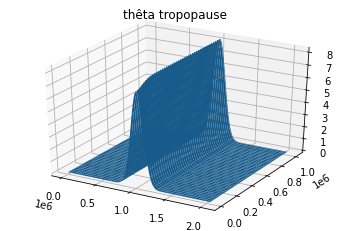

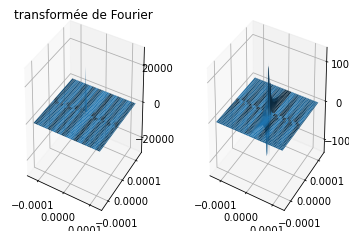

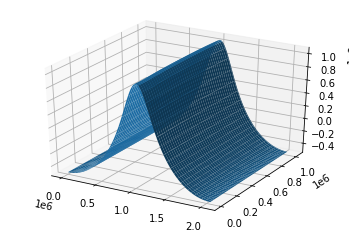

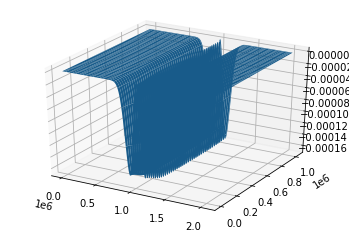

In [101]:
# Initial data
a, b = 1024e3, 2048e3
Pa, Pb = 128, 256 # samples
thetatp = np.zeros((Pa,Pb))

# pseudo-filament
import scipy.ndimage as spnd 
Px = 8 
Py = 64
thetaanom = 15
for i in range(Pa): 
    for j in range(Pb):
        if abs(i-Pa/2) < Px and abs(j-Pb/2) < Py:
            thetatp[i,j] = thetaanom
spnd.gaussian_filter(thetatp, 10, output=thetatp)

if demo:
    for i in range(Pa): # example data
        for j in range(Pb):
            thetatp[i,j] = np.sin(2*np.pi*i/Pa)*np.sin(2*np.pi*j/Pb)

plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(np.linspace(0,b,Pb), np.linspace(0,a,Pa))
ax.plot_surface(X,Y,thetatp)
plt.title("thêta tropopause")
plt.show()


# main script
thetatphat = np.fft.fft2(thetatp)

fig = plt.figure()
ax = fig.add_subplot(1,2,1, projection='3d')
Xf,Yf = np.meshgrid(np.linspace(-Pb/b, Pb/b, Pb),\
                  np.linspace(-Pa/a, Pa/a, Pa)) # need even Pa, Pb
ax.plot_surface(Xf,Yf,np.fft.fftshift(thetatphat).real)
plt.title("transformée de Fourier")
ax = plt.subplot(1,2,2, projection='3d')
ax.plot_surface(Xf,Yf,np.fft.fftshift(thetatphat).imag)

plt.show()

z = -1000
psi, test = streamfunc(a,b,Pa,Pb,thetatphat,z, demo)

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,psi)
plt.show()

dttp = tempanomvar(a,b,Pa,Pb,thetatp,psi)

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,dttp)
plt.show()